In [1]:
import pandas as pd
import yfinance as yf

In [2]:
!pip install chart_studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.8 MB/s eta 0:00:00


In [3]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.3 MB/s eta 0:00:00


# Automated code to check all FIIs and calculate a confusion matrix

In [4]:
############################################
#### function to predict 3 months
############################################

def predict_3_mo(tic):
  msft = yf.Ticker(tic+".SA")

  # get historical market data
  hist = msft.history(period="max", interval = "1mo")

  if ((not hist.empty) and (len(hist) >= 12)):
    hist.drop(columns=['Open','High','Low','Volume','Dividends','Stock Splits'],inplace=True)

    hist.index = pd.to_datetime(hist.index)
    hist.index = hist.index.date

    df = hist.copy()
    # Find the indices of null values in the 'Close' column
    null_indices = df[df['Close'].isnull()].index

    # Iterate through each null value and fill it with the average of the closest two non-null values
    for idx in null_indices:
        # Find the closest non-null values before and after the null value
        before_idx = df[df.index < idx]['Close'].dropna().index.max()
        after_idx = df[df.index > idx]['Close'].dropna().index.min()

        # Calculate the average of the closest non-null values
        if before_idx is not None and after_idx is not None:
            avg_value = (df.loc[before_idx, 'Close'] + df.loc[after_idx, 'Close']) / 2
        elif before_idx is not None:
            avg_value = df.loc[before_idx, 'Close']
        elif after_idx is not None:
            avg_value = df.loc[after_idx, 'Close']
        else:
            avg_value = None

        # Fill the null value with the calculated average
        df.loc[idx, 'Close'] = avg_value

    hist = df.copy()
    hist.index = pd.to_datetime(hist.index)
    hist.index = hist.index.date

    ### trying auto arima
    if (len(hist) <= 24):
      period=6
    else:
      period=12

    stepwise_model = auto_arima(hist, start_p=1, start_q=1,
                              max_p=3, max_q=3, m=period,
                              start_P=0, seasonal=True,
                              d=1, D=1,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True,
                              trace=False)
    print(tic,", aic = ",stepwise_model.aic())
    stepwise_model_future = stepwise_model

    # get train-test
    train = hist.iloc[:-3]
    test = hist.iloc[-3:]

    # train the model
    stepwise_model.fit(train)

    # predict the test
    future_forecast = stepwise_model.predict(n_periods=len(test))
    #print(future_forecast)

    ## check how it went
    future_forecast = pd.DataFrame(list(future_forecast.values),index = test.index)
    p_local = pd.concat([test,future_forecast],axis=1)

    p_tot = pd.concat([hist,future_forecast],axis=1)

    actual = train.iloc[-1].item()

    ## predicting with mean values
    #pred = future_forecast.mean().item()
    #real = test.mean().item()

    ## prediction with max values
    pred = future_forecast.max().item()
    real = test.max().item()

    real=real/actual
    pred=pred/actual

    # predict the future
    stepwise_model_future.fit(hist)
    future = stepwise_model_future.predict(n_periods=3)

    return p_local,p_tot,real,pred,future
  else:
    return None,None,None,None,None

In [ ]:
#### load around all FIIs
import pandas as pd
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
from sklearn.metrics import confusion_matrix
import pandas as pd

plot_test = []
plot_total = []
y_test = []
y_pred = []
predicted_fiis = []
future_values = []

## reading tickers
fiis = pd.read_csv('all-fiis.csv',header=None)
fiis['ticker']=fiis[1].str.split(';').str[1]
fiis = fiis[~fiis['ticker'].isnull()]

tickers = list(fiis['ticker'])

for t in tickers:
  a,b,real,pred,fut=predict_3_mo(t)

  if (real != None and pred!= None):
    plot_test.append(a)
    plot_total.append(b)
    predicted_fiis.append(t)
    future_values.append(fut)

    if (real >= 1.0):
      y_test.append(1)
    else:
      y_test.append(0)

    if (pred >= 1.0):
      y_pred.append(1)
    else:
      y_pred.append(0)


KNIP11 , aic =  298.8831475320853
KNCR11 , aic =  464.73249292090236
HGLG11 , aic =  957.3121509039245
KNRI11 , aic =  679.5528784710856
IRDM11 , aic =  189.04730503268132
XPLG11 , aic =  188.18378958671585
MXRF11 , aic =  151.76714669810173
XPML11 , aic =  168.96728641836165
CPTS11 , aic =  41.94125903569352
HGRU11 , aic =  336.1066439919306
RECR11 , aic =  89.2472561329394
VISC11 , aic =  390.5786056095323
BTLG11 , aic =  602.4419824671613
HGBS11 , aic =  980.8036581924747
KNHY11 , aic =  268.44584030398687
HFOF11 , aic =  332.72237720337864
BCFF11 , aic =  83.2373299313711


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


BRCR11 , aic =  615.579458180309
BRCO11 , aic =  211.795586101524
TGAR11 , aic =  329.1860416556851
HGRE11 , aic =  1135.102059135602
JSRE11 , aic =  578.9301730293512
HGCR11 , aic =  544.4900807022331
VILG11 , aic =  303.6435636768577
MCCI11 , aic =  175.95243826544578
BBPO11 , aic =  649.610486976384
HSML11 , aic =  264.81927539412345
VRTA11 , aic =  593.8547195400819
LVBI11 , aic =  212.65764102931288
TRXF11 , aic =  170.88905099440282
VCJR11 , aic =  171.3185872238136
RBVA11 , aic =  296.10473215024615
RBRR11 , aic =  275.8317660615331
HCTR11 , aic =  286.29101370337634


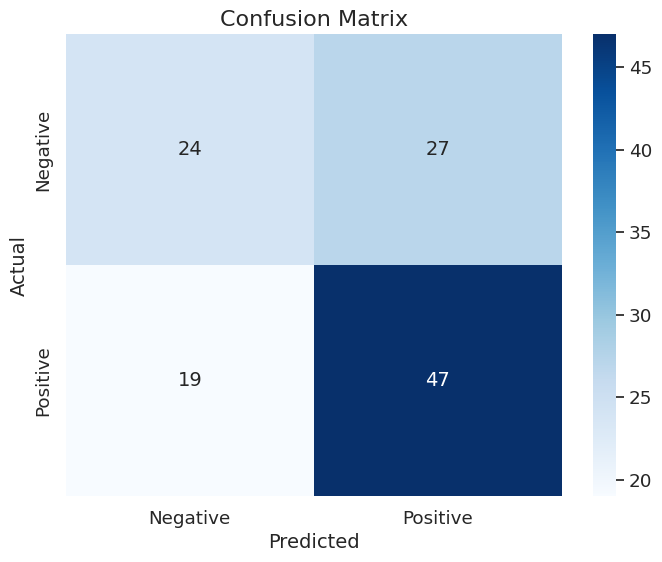

Accuracy: 0.6068376068376068
Precision: 0.6351351351351351
Recall: 0.7121212121212122
F1-score: 0.6714285714285715

Classification Report:
               precision    recall  f1-score   support

    Negative       0.56      0.47      0.51        51
    Positive       0.64      0.71      0.67        66

    accuracy                           0.61       117
   macro avg       0.60      0.59      0.59       117
weighted avg       0.60      0.61      0.60       117



In [ ]:
### ploting confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

## create table
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class labels
class_labels = ["Negative", "Positive"]

# Create a figure and axis
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size if needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 14})

# Add labels, title, and axis ticks
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5], labels=class_labels)

# Display the plot
plt.show()

# Calculate metrics
y_true = y_test
y_pred = y_pred
#
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("\nClassification Report:\n", report)

# Saving results

In [ ]:
from google.colab import files

### we want to sav four things:
# plot_test
# plot_total
# y_test
# y_pred
# predicted_fiis
# future_values

## lets create a dataframe with the model
data = {
    'Predicted_FIIs': predicted_fiis,
    'Y_Test': y_test,
    'Y_Pred': y_pred
}
df_model = pd.DataFrame(data)

# future values in dataframe
fut_values = []
for series in future_values:
    mean = series.mean()
    fut_values.append(mean)
df_model['Mean_of_Future_Values_3_mo'] = fut_values

# max of future values in dataframe
fut_values_max = []
for series in future_values:
    max = series.max()
    fut_values_max.append(max)
df_model['Max_of_Future_Values_3_mo'] = fut_values_max

#current value of 2023-11-01 on dataframe
current_values = []
for a in plot_test:
  a.index = pd.to_datetime(a.index)
  val = a.loc['2023-11-01', 'Close']
  current_values.append(val)
df_model['Value_2023_11_01'] = current_values

####
####   saving
####
import pickle
from google.colab import drive

# Specify the file path where you want to save the list of DataFrames
file_path1 = folder_path + 'plot_test.pkl'
file_path2 = folder_path + 'plot_total.pkl'

files.download(file_path1)
files.download(file_path2)

# Specify the file path where you want to save the CSV file
file_path = 'df_model.csv'

# Save the DataFrame to a CSV file
df_model.to_csv(file_path, index=False)  # Set index=False to avoid writing row numbers
files.download(file_path)

# save the future values
file_path3 = folder_path + 'future_values.pkl'

files.download(file_path3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# save the future values
file_path4 = 'future_values.pkl'

files.download(file_path4)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>